# MPB 3D waveguide modeling

initial testing

In [3]:
# preamble

from pathlib import Path
from multiprocessing import Pool
import socket
import pickle
from datetime import datetime
from time import time
from os import path, makedirs, chmod
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import meep as mp
import meep.materials as mats
from meep import mpb
import meep.adjoint as mpa
# import meeputils as mu
from wurlitzer import pipes, STDOUT
from io import StringIO
# from pint import UnitRegistry
# u = UnitRegistry()

from scipy.interpolate import RectBivariateSpline
# my additions
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.optimize as opt
import warnings
import h5py
import sys
from mpb_adj import OptimizationProblem


# material fns
### import index models ###
home = str( Path.home() )
nlo_dir = home+'/github/optics_modeling/nlo'
if nlo_dir not in sys.path:
    sys.path.append(nlo_dir)
import NLO_tools as nlo

u = nlo.u

def _n_linbo3(λ,T=300*u.degK,axis='e'):
    return nlo.n_MgO_LN(λ*u.um,T,axis=axis)[0,0]

def _ng_linbo3(λ,T=300*u.degK,axis='e'):
    return nlo.n_g_MgO_LN(λ*u.um,T,axis=axis)

def _n_si3n4(λ,T=300*u.degK):
    return nlo.n_Si3N4(λ*u.um,T)[0,0]

def _ng_si3n4(λ,T=300*u.degK):
    return nlo.n_g_Si3N4(λ*u.um,T)

def _n_sio2(λ,T=300*u.degK):
    return nlo.n_SiO2(λ*u.um,T)[0,0]

def _ng_sio2(λ,T=300*u.degK):
    return nlo.n_g_SiO2(λ*u.um,T)

def _n_mgf2(λ,T=300*u.degK):
    return nlo.n_MgF2(λ*u.um,T)

def _ng_mgf2(λ,T=300*u.degK):
    return nlo.n_g_MgF2(λ*u.um,T)

# n_Si3N4(lm_in,T_in)

### Cauchy Equation fit coefficients for Gavin's ALD alumina films ###
# Eqn. form:
# n = A + B / lam**2 + C / lam**4
# ng = A + 3 * B / lam**2 + 5 * C / lam**4
A_alumina = 1.602
B_alumina = 0.01193
C_alumina = -0.00036


### Cauchy Equation fit coefficients for 100nm Hafnia (HfO2) films ###
## taken from
## Khoshman and Kordesch. "Optical properties of a-HfO2 thin films." Surface and Coatings Technology 201.6 (2006)
## great fit to measured data from sputtered amorphous Hafnia, haven't found one for ALD Hafnia specifically
## they also report loss, with a sharp absorption edge near 5.68 ± 0.09 eV (~218 nm)
# Eqn. form:
# n = A + B / lam**2 + C / lam**4
# ng = A + 3 * B / lam**2 + 5 * C / lam**4

# # fit for spectroscopic ellipsometer measurement for a 250nm thick film, good 300-1400nm
# A_hafnia = 1.85
# B_hafnia = 1.17e-8
# C_hafnia = 0.0

# fit for spectroscopic ellipsometer measurement for a 112nm thick film, good 300-1400nm
A_hafnia = 1.86
B_hafnia = 7.16e-9
C_hafnia = 0.0

# In_{1-x} Ga_x As_y P_{1-y}
# Modified single-oscillator model
# F. Fiedler and A. Schlachetzki. Optical parameters of InP-based waveguides.
#   Solid-State Electronics, 30(1):73–83, 1987.
def _n_ingaasp(y, lam_mu):
    Ed = 28.91 - 9.278 * y + 5.626 * y ** 2
    E0 = 3.391 - 1.652 * y + 0.863 * y ** 2 - 0.123 * y ** 3
    Eg = 1.35 - 0.72 * y + 0.12 * y ** 2
    Eph = 1.24 / lam_mu
    return np.sqrt(np.abs(1 + Ed / E0 + Ed * Eph ** 2 / E0 ** 3 + Ed * Eph ** 4 / (2 * E0 ** 3 * (E0 ** 2 - Eg ** 2)) *
                          np.log((2 * E0 ** 2 - Eg ** 2 - Eph ** 2) / (Eg ** 2 - Eph ** 2))))


# Just take the derivative: n_g = n + (omega/2n) d(n^2)/d(omega)
def _ng_ingaasp(y, lam_mu):
    n = _n_ingaasp(y, lam_mu);
    hw = 1.24 / lam_mu;
    Ed = 28.91 - 9.278 * y + 5.626 * y ** 2
    E0 = 3.391 - 1.652 * y + 0.863 * y ** 2 - 0.123 * y ** 3
    Eg = 1.35 - 0.72 * y + 0.12 * y ** 2
    return (n + 1 / (2 * n) * ((2 * Ed * hw ** 2) / E0 ** 3 + (2 * Ed * (hw ** 4)) / E0 ** 3 * (
                hw ** 2 / ((2 * E0 ** 2 - Eg ** 2 - hw ** 2) * (Eg ** 2 - hw ** 2)) +
                1 / (E0 ** 2 - Eg ** 2) * np.log((2 * E0 ** 2 - Eg ** 2 - hw ** 2) / (Eg ** 2 - hw ** 2)))))


# Lambda is in microns here.
def get_index(mat, lam):
    lam = lam
    if (mat == 'Si3N4'):
        # 1) H. R. Philipp. Optical properties of silicon nitride,
        #    J. Electrochim. Soc. 120, 295-300 (1973)
        # 2) T. Baak. Silicon oxynitride; a material for GRIN optics,
        #    Appl. Optics 21, 1069-1072 (1982)
        # return np.sqrt(1 + (2.8939 * lam ** 2) / (lam ** 2 - 0.1396 ** 2))
        return _n_si3n4(lam)
    elif (mat == 'SiO2'):
        # I. H. Malitson. Interspecimen Comparison of the Refractive Index of Fused Silica,
        # J. Opt. Soc. Am. 55, 1205-1208 (1965)
        # return np.sqrt(
        #     np.maximum(1 + (0.6961 * lam ** 2) / (lam ** 2 - 0.06840 ** 2) + (0.4079 * lam ** 2) / (lam ** 2 - 0.1162 ** 2)
        #     + (0.8974 * lam ** 2) / (lam ** 2 - 9.8961 ** 2), 1))
        return _n_sio2(lam)
    elif (mat == 'MgF2'):
        return _n_mgf2(lam)
    elif (mat == 'Si'):
        # 1) C. D. Salzberg and J. J. Villa. Infrared Refractive Indexes of Silicon,
        #    Germanium and Modified Selenium Glass, J. Opt. Soc. Am., 47, 244-246 (1957)
        # 2) B. Tatian. Fitting refractive-index data with the Sellmeier dispersion formula,
        #    Appl. Opt. 23, 4477-4485 (1984)
        return np.sqrt(
            1 + (10.6684 * lam ** 2) / (lam ** 2 - 0.3015 ** 2) + (0.003043 * lam ** 2) / (lam ** 2 - 1.1347 ** 2)
            + (1.5413 * lam ** 2) / (lam ** 2 - 1104 ** 2))
    elif (mat == 'Alumina'):
        return A_alumina + B_alumina / lam**2 + C_alumina / lam**4  # Cauchy Eqn. fit from Gavin's ALD alumina
    elif (mat == 'Hafnia'):
        return A_hafnia + B_hafnia / lam**2 + C_hafnia / lam**4  # Cauchy Eqn. fit from cited paper above for sputtered Hafnia
    elif (mat == 'Air'):
        return 1.0
    elif (mat == 'InP'):
        return _n_ingaasp(0, lam)
    elif (mat == 'LiNbO3'):
        return _n_linbo3(lam)
    elif (type(mat) == str and mat.startswith('InGaAsP_Q')):
        Eg = 1.24 / float(mat[9:])
        assert (0.75 <= Eg <= 1.35)
        y = (0.72 - np.sqrt(0.72 ** 2 - 4 * (0.12) * (1.35 - Eg))) / (2 * 0.12)
        return _n_ingaasp(y, lam)
    elif (type(mat) in [int, float, np.float64]):
        return mat
    else:
        raise ValueError("Material " + mat + " not supported.")


def get_ng(mat, lam):
    if (mat == 'InP'):
        return _ng_ingaasp(0, lam * 1e6)
    elif (mat == 'Si3N4'):
        return _ng_si3n4(lam)
    elif (mat == 'SiO2'):
        return _ng_sio2(lam)
    elif (mat == 'MgF2'):
        return _ng_mgf2(lam)
    elif (mat == 'LiNbO3'):
        return _ng_linbo3(lam)
    elif (mat == 'Air'):
        return 1.0
    elif (mat == 'Alumina'):
        return A_alumina + 3 * B_alumina / lam**2 + 5 * C_alumina / lam**4  # Cauchy Eqn. fit from Gavin's ALD alumina, analytic derivative for ng
    elif (mat == 'Hafnia'):
        return A_hafnia + 3 * B_hafnia / lam**2 + 5* C_hafnia / lam**4  # Cauchy Eqn. fit from cited paper above for sputtered Hafnia
    elif (mat.startswith('InGaAsP_Q')):
        Eg = 1.24 / float(mat[9:])
        assert (0.75 <= Eg <= 1.35)
        y = (0.72 - np.sqrt(0.72 ** 2 - 4 * (0.12) * (1.35 - Eg))) / (2 * 0.12)
        return _ng_ingaasp(y, lam * 1e6)
    else:
        # A lazy hack...
        [n100, n101, n099] = [get_index(mat, lam / x) for x in [1.00, 1.01, 0.99]]
        w0 = 2 * np.pi * 3e8 / lam
        dndw = (n101 - n099) / (0.02 * w0)
        return (dndw * w0 + n100)

In [7]:
# geometry and solver parameters

# define new parameters for angled sidewalls, partial etch, conformal deposited layers after wg etch,

θ = 0. # sidewall angle in degrees, 0 = vertical
w_top = 0.4*u.um #0.2*u.um # top width of partially etched "core layer" in microns
t_core = 0.5*u.um # full thickness of "core layer" in microns
t_etch = 0.3*u.um #0.15 # etch depth into "core layer" in microns
r_hole = 0.1*u.um

lam = 0.85*u.um # free space wavelength in microns
dx_base = np.tan(np.deg2rad(θ)) * t_etch
nk = 20
mat_core = 'Alumina'
mat_clad = 'SiO2'
Xgrid = 2
Ygrid = 2
Zgrid = 1
n_modes = 4
res_x = 32
res_y = 32
res_z = 32
res = mp.Vector3(res_x,res_y,res_z)
do_func = None

# manually convert to unitless quantities for now
w_top = w_top.to(u.um).m
t_core = t_core.to(u.um).m
t_etch = t_etch.to(u.um).m
r_hole = r_hole.to(u.um).m
lam = lam.to(u.um).m
#ω = 1/lam # frequency in units of c

band_funcs = [mpb.fix_efield_phase,
                       mpb.output_efield,
#                            mpb.output_hfield,
#                            mpb.output_dpwr,
#                            mpb.output_poynting,
#                            mpb.output_tot_pwr,
                       #mpb.output_dpwr_in_objects,
                      ]

# get phase and group indices for these materials at this wavelength
n_core =  get_index(mat_core, lam); ng_core =  get_ng(mat_core, lam)
n_clad =  get_index(mat_clad, lam); ng_clad = get_ng(mat_clad, lam)
med_core = mp.Medium(index=n_core); med_clad = mp.Medium(index=n_clad)

In [ ]:
# initialize solver

# compute a few more useful quantities with user parameters
nx = Xgrid * res_x
ny = Ygrid * res_y
nz = Zgrid * res_z

x = Xgrid * np.linspace(-1/2., 1/2., nx)
y = Ygrid * np.linspace(-1/2., 1/2., ny)
z = Zgrid * np.linspace(-1/2., 1/2., nz)

# k_points = [mp.Vector3(0, 0, 2.8),]
k_points = [mp.Vector3(), mp.Vector3(0, 0, 0.5)]
k_points = mp.interpolate(nk, k_points)
kz = np.array([np.array(kk)[2] for kk in k_points])

# define geometry with design region
lat = mp.Lattice(size=mp.Vector3(Xgrid, Ygrid, Zgrid))
dx_base = np.tan(np.deg2rad(θ)) * t_etch

verts_core = [mp.Vector3(-w_top/2.,t_etch/2),
        mp.Vector3(w_top/2.,t_etch/2),
        mp.Vector3(w_top/2+dx_base,-t_etch/2),
        mp.Vector3(-w_top/2-dx_base,-t_etch/2),
       ]
core = mp.Prism(verts_core, height=mp.inf, material=med_core)

holes = [mp.Cylinder(center=mp.Vector3(0,0,0.25),
                     height=mp.inf,
                     radius=r_hole,
                     axis=mp.Vector3(0,1,0),
                     material=med_clad,
                    ),
         mp.Cylinder(center=mp.Vector3(0,0,-0.25),
                     height=mp.inf,
                     radius=r_hole,
                     axis=mp.Vector3(0,1,0),
                     material=med_clad,
                    ),
        ]

if t_etch<t_core:   # partial etch
    slab = mp.Block(size=mp.Vector3(mp.inf,
                                    t_core-t_etch,
                                    mp.inf,),
                    center=mp.Vector3(0,
                                      -(t_core-t_etch)/2,
                                      0,),
                    material=med_core)
    geom = [core,slab,] + holes
else:
    geom = [core,] + holes


# instantiate ModeSolver and solve for a few modes

blackhole = StringIO()
with pipes(stdout=blackhole, stderr=STDOUT):
    ms = mpb.ModeSolver(geometry_lattice=lat,
                        geometry=[],
                        k_points=k_points,
                        resolution=res,
                        num_bands=n_modes,
                        default_material=med_clad)
    ms.geometry = geom
    ms.default_material = med_clad
    ms.init_params(mp.NO_PARITY, False)
    ms.run(*band_funcs)

E = np.stack([np.array(ms.get_efield(mind+1)) for mind in range(n_modes)],axis=-1)
ω = np.array(ms.all_freqs)
neff = kz[:,np.newaxis] / ω

Working in 3 dimensions.
Grid size is 64 x 64 x 32.
Solving for 4 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (2, 0, 0)
     (0, 2, 0)
     (0, 0, 1)
Cell volume = 4
Reciprocal lattice vectors (/ 2 pi):
     (0.5, -0, 0)
     (-0, 0.5, -0)
     (0, -0, 1)
Geometric objects:
     prism, center = (0,0,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-0.2,0.15,0)
          (0.2,0.15,0)
          (0.2,-0.15,0)
          (-0.2,-0.15,0)
     block, center = (0,-0.1,0)
          size (1e+20,0.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     cylinder, center = (0,0,0.25)
          radius 0.1, height 1e+20, axis (0, 1, 0)
     cylinder, center = (0,0,-0.25)
          radius 0.1, height 1e+20, axis (0, 1, 0)
Geometric object tree has depth 2 and 28 object nodes (vs. 4 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...

  Vector3<0.0, 0.0, 0.4013605442176871>
  Vector3<0.0, 0.0, 0.40249433106575966>
  Vector3<0.0, 0.0, 0.4036281179138322>
  Vector3<0.0, 0.0, 0.40476190476190477>
  Vector3<0.0, 0.0, 0.40589569160997735>
  Vector3<0.0, 0.0, 0.4070294784580499>
  Vector3<0.0, 0.0, 0.40816326530612246>
  Vector3<0.0, 0.0, 0.409297052154195>
  Vector3<0.0, 0.0, 0.41043083900226757>
  Vector3<0.0, 0.0, 0.41156462585034015>
  Vector3<0.0, 0.0, 0.4126984126984127>
  Vector3<0.0, 0.0, 0.41383219954648526>
  Vector3<0.0, 0.0, 0.41496598639455784>
  Vector3<0.0, 0.0, 0.41609977324263037>
  Vector3<0.0, 0.0, 0.41723356009070295>
  Vector3<0.0, 0.0, 0.4183673469387755>
  Vector3<0.0, 0.0, 0.41950113378684806>
  Vector3<0.0, 0.0, 0.42063492063492064>
  Vector3<0.0, 0.0, 0.42176870748299317>
  Vector3<0.0, 0.0, 0.42290249433106575>
  Vector3<0.0, 0.0, 0.4240362811791383>
  Vector3<0.0, 0.0, 0.42517006802721086>
  Vector3<0.0, 0.0, 0.42630385487528344>
  Vector3<0.0, 0.0, 0.42743764172335597>
  Vector3<0.0, 0.0, 0.42

Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 7, 0, 0, 0.00680272, 0.00680272, 0.00462334, 0.00463259, 0.336003, 0.336121
elapsed time for k point: 0.49016237258911133
Fixing e-field (band 1) phase by 1 + 6.3383e-10i; max ampl. = 0.368147
Fixing e-field (band 2) phase by -0.999921 + -0.0126034i; max ampl. = 0.363926
Fixing e-field (band 3) phase by -0.511586 + 0.859232i; max ampl. = 0.598468
Fixing e-field (band 4) phase by 0.999992 + -0.0039741i; max ampl. = 0.504868
Outputting fields to e.k07.b01.h5...
Outputting fields to e.k07.b02.h5...
Outputting fields to e.k07.b03.h5...
Outputting fields to e.k07.b04.h5...
solve_kpoint (0,0,0.00793651):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 8, 0, 0, 0.00793651, 0.00793651, 0.00539393, 0.00540469, 0.336015, 0.336132
elapsed time for k point: 0.45183897018432617
Fixing e-field (band 1) phase by 1 + 6.64945e-10i; max ampl. = 0.36823
Fixing e-field (band 2) phase by -0.975513 + -0.2

solve_kpoint (0,0,0.0204082):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 19, 0, 0, 0.0204082, 0.0204082, 0.0138698, 0.0138977, 0.336263, 0.336369
elapsed time for k point: 0.4595050811767578
Fixing e-field (band 1) phase by 1 + -6.60962e-10i; max ampl. = 0.367508
Fixing e-field (band 2) phase by 0.993164 + 0.116725i; max ampl. = 0.361527
Fixing e-field (band 3) phase by -0.500319 + 0.865841i; max ampl. = 0.598051
Fixing e-field (band 4) phase by -1 + 0.000642838i; max ampl. = 0.50494
Outputting fields to e.k19.b01.h5...
Outputting fields to e.k19.b02.h5...
Outputting fields to e.k19.b03.h5...
Outputting fields to e.k19.b04.h5...
solve_kpoint (0,0,0.021542):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 20, 0, 0, 0.021542, 0.021542, 0.0146403, 0.0146698, 0.336296, 0.336401
elapsed time for k point: 0.4280109405517578
Fixing e-field (band 1) phase by 1 + 5.41612e-10i; max ampl. = 0.367794
Fixing e-

solve_kpoint (0,0,0.0340136):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 31, 0, 0, 0.0340136, 0.0340136, 0.0231162, 0.0231628, 0.336782, 0.336866
elapsed time for k point: 0.36130642890930176
Fixing e-field (band 1) phase by 1 + -4.36032e-10i; max ampl. = 0.367798
Fixing e-field (band 2) phase by -0.94693 + 0.321441i; max ampl. = 0.362385
Fixing e-field (band 3) phase by -0.0586965 + -0.998276i; max ampl. = 0.597312
Fixing e-field (band 4) phase by 1 + -2.66873e-05i; max ampl. = 0.505068
Outputting fields to e.k31.b01.h5...
Outputting fields to e.k31.b02.h5...
Outputting fields to e.k31.b03.h5...
Outputting fields to e.k31.b04.h5...
solve_kpoint (0,0,0.0351474):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 32, 0, 0, 0.0351474, 0.0351474, 0.0238867, 0.0239349, 0.336837, 0.336919
elapsed time for k point: 0.3928806781768799
Fixing e-field (band 1) phase by 1 + 8.65017e-11i; max ampl. = 0.367886
Fi

solve_kpoint (0,0,0.047619):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 43, 0, 0, 0.047619, 0.047619, 0.0323625, 0.0324279, 0.33756, 0.33761
elapsed time for k point: 0.4071927070617676
Fixing e-field (band 1) phase by 1 + -7.57717e-11i; max ampl. = 0.36795
Fixing e-field (band 2) phase by 0.998841 + 0.0481294i; max ampl. = 0.362704
Fixing e-field (band 3) phase by 0.979186 + 0.202967i; max ampl. = 0.596243
Fixing e-field (band 4) phase by 1 + -1.5635e-05i; max ampl. = 0.505299
Outputting fields to e.k43.b01.h5...
Outputting fields to e.k43.b02.h5...
Outputting fields to e.k43.b03.h5...
Outputting fields to e.k43.b04.h5...
solve_kpoint (0,0,0.0487528):
Solving for bands 1 to 4...
freqs:, 44, 0, 0, 0.0487528, 0.0487528, 0.033133, 0.0332, 0.337636, 0.337683
elapsed time for k point: 0.40718913078308105
Fixing e-field (band 1) phase by 1 + 4.05842e-10i; max ampl. = 0.367992
Fixing e-field (band 2) phase by 0.934348 + -0.356362i; max ampl. = 0

    iteration    1: trace = 0.2327648000703592 (5.96011e-06% change)
Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 55, 0, 0, 0.0612245, 0.0612245, 0.0416087, 0.0416928, 0.338593, 0.3386
elapsed time for k point: 0.5658948421478271
Fixing e-field (band 1) phase by 1 + -2.5784e-10i; max ampl. = 0.367981
Fixing e-field (band 2) phase by -0.907492 + -0.420069i; max ampl. = 0.362471
Fixing e-field (band 3) phase by -0.94215 + 0.335193i; max ampl. = 0.594896
Fixing e-field (band 4) phase by 1 + 1.23941e-06i; max ampl. = 0.505631
Outputting fields to e.k55.b01.h5...
Outputting fields to e.k55.b02.h5...
Outputting fields to e.k55.b03.h5...
Outputting fields to e.k55.b04.h5...
solve_kpoint (0,0,0.0623583):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 56, 0, 0, 0.0623583, 0.0623583, 0.0423792, 0.0424649, 0.338691, 0.338693
elapsed time for k point: 0.37870335578918457
Fixing e-field (band 1) phase by 1 + 5.05868e-11i; max ampl. = 0.368

Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 67, 0, 0, 0.0748299, 0.0748299, 0.0508548, 0.0509577, 0.339832, 0.339881
elapsed time for k point: 0.37071871757507324
Fixing e-field (band 1) phase by 1 + -1.17128e-10i; max ampl. = 0.368099
Fixing e-field (band 2) phase by -0.994938 + -0.100489i; max ampl. = 0.362465
Fixing e-field (band 3) phase by -1 + -9.05498e-07i; max ampl. = 0.506044
Fixing e-field (band 4) phase by -0.951005 + 0.309176i; max ampl. = 0.593196
Outputting fields to e.k67.b01.h5...
Outputting fields to e.k67.b02.h5...
Outputting fields to e.k67.b03.h5...
Outputting fields to e.k67.b04.h5...
solve_kpoint (0,0,0.0759637):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 68, 0, 0, 0.0759637, 0.0759637, 0.0516253, 0.0517298, 0.339946, 0.34
elapsed time for k point: 0.35637688636779785
Fixing e-field (band 1) phase by 1 + 8.46516e-11i; max ampl. = 0.368188
Fixing e-field (band 2) phase by 0

Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 79, 0, 0, 0.0884354, 0.0884354, 0.0601007, 0.0602224, 0.341306, 0.34142
elapsed time for k point: 0.38519835472106934
Fixing e-field (band 1) phase by 1 + -9.52364e-11i; max ampl. = 0.368318
Fixing e-field (band 2) phase by -0.934718 + -0.355391i; max ampl. = 0.362687
Fixing e-field (band 3) phase by 1 + 4.6374e-07i; max ampl. = 0.506492
Fixing e-field (band 4) phase by 0.967591 + -0.252522i; max ampl. = 0.591179
Outputting fields to e.k79.b01.h5...
Outputting fields to e.k79.b02.h5...
Outputting fields to e.k79.b03.h5...
Outputting fields to e.k79.b04.h5...
solve_kpoint (0,0,0.0895692):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 80, 0, 0, 0.0895692, 0.0895692, 0.0608712, 0.0609944, 0.341439, 0.341559
elapsed time for k point: 0.37081336975097656
Fixing e-field (band 1) phase by 1 + 5.48475e-11i; max ampl. = 0.368404
Fixing e-field (band 2) phase by 0

Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 91, 0, 0, 0.102041, 0.102041, 0.0693463, 0.0694869, 0.343017, 0.343206
elapsed time for k point: 0.3713560104370117
Fixing e-field (band 1) phase by 1 + -5.67762e-11i; max ampl. = 0.368557
Fixing e-field (band 2) phase by 0.96621 + -0.257755i; max ampl. = 0.36293
Fixing e-field (band 3) phase by 1 + -2.23596e-07i; max ampl. = 0.507053
Fixing e-field (band 4) phase by -0.944418 + 0.328747i; max ampl. = 0.588922
Outputting fields to e.k91.b01.h5...
Outputting fields to e.k91.b02.h5...
Outputting fields to e.k91.b03.h5...
Outputting fields to e.k91.b04.h5...
solve_kpoint (0,0,0.103175):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 92, 0, 0, 0.103175, 0.103175, 0.0701168, 0.070259, 0.34317, 0.343366
elapsed time for k point: 0.3947455883026123
Fixing e-field (band 1) phase by 1 + 6.7599e-11i; max ampl. = 0.36861
Fixing e-field (band 2) phase by 0.0396623 + 

Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 103, 0, 0, 0.115646, 0.115646, 0.0785917, 0.0787513, 0.344962, 0.345236
elapsed time for k point: 0.39415812492370605
Fixing e-field (band 1) phase by 1 + -6.28023e-11i; max ampl. = 0.368787
Fixing e-field (band 2) phase by -0.942776 + -0.333426i; max ampl. = 0.362977
Fixing e-field (band 3) phase by 1 + -2.64133e-07i; max ampl. = 0.507685
Fixing e-field (band 4) phase by 0.993653 + -0.112492i; max ampl. = 0.586418
Outputting fields to e.k103.b01.h5...
Outputting fields to e.k103.b02.h5...
Outputting fields to e.k103.b03.h5...
Outputting fields to e.k103.b04.h5...
solve_kpoint (0,0,0.11678):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 104, 0, 0, 0.11678, 0.11678, 0.0793622, 0.0795233, 0.345134, 0.345416
elapsed time for k point: 0.41633057594299316
Fixing e-field (band 1) phase by 1 + 5.07136e-11i; max ampl. = 0.368874
Fixing e-field (band 2) phase by 0.882798 + 0.469754i; max am

Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 115, 0, 0, 0.129252, 0.129252, 0.0878369, 0.0880154, 0.347137, 0.347506
elapsed time for k point: 0.3974452018737793
Fixing e-field (band 1) phase by 1 + -6.99065e-11i; max ampl. = 0.369079
Fixing e-field (band 2) phase by -0.853189 + -0.521603i; max ampl. = 0.363195
Fixing e-field (band 3) phase by 1 + -6.21019e-07i; max ampl. = 0.508422
Fixing e-field (band 4) phase by 0.994224 + -0.107322i; max ampl. = 0.58373
Outputting fields to e.k115.b01.h5...
Outputting fields to e.k115.b02.h5...
Outputting fields to e.k115.b03.h5...
Outputting fields to e.k115.b04.h5...
solve_kpoint (0,0,0.130385):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 116, 0, 0, 0.130385, 0.130385, 0.0886073, 0.0887874, 0.347328, 0.347706
elapsed time for k point: 0.41437697410583496
Fixing e-field (band 1) phase by 1 + 7.07945e-11i; max ampl. = 0.369149
Fixing e-field (band 2) phase by

Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 127, 0, 0, 0.142857, 0.142857, 0.0970816, 0.0972793, 0.349538, 0.350011
elapsed time for k point: 0.4505791664123535
Fixing e-field (band 1) phase by 1 + -8.8905e-11i; max ampl. = 0.3694
Fixing e-field (band 2) phase by 0.948325 + -0.3173i; max ampl. = 0.363396
Fixing e-field (band 3) phase by 1 + -8.66052e-07i; max ampl. = 0.509204
Fixing e-field (band 4) phase by -0.999889 + 0.0148693i; max ampl. = 0.580844
Outputting fields to e.k127.b01.h5...
Outputting fields to e.k127.b02.h5...
Outputting fields to e.k127.b03.h5...
Outputting fields to e.k127.b04.h5...
solve_kpoint (0,0,0.143991):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 128, 0, 0, 0.143991, 0.143991, 0.097852, 0.0980513, 0.349748, 0.35023
elapsed time for k point: 0.509068489074707
Fixing e-field (band 1) phase by 1 + 9.23396e-11i; max ampl. = 0.369476
Fixing e-field (band 2) phase by 0.643493 + 0.765452i; max ampl. = 0

solve_kpoint (0,0,0.156463):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 139, 0, 0, 0.156463, 0.156463, 0.106326, 0.106543, 0.35216, 0.352745
elapsed time for k point: 0.43465662002563477
Fixing e-field (band 1) phase by 1 + -1.42484e-12i; max ampl. = 0.369761
Fixing e-field (band 2) phase by 0.772294 + 0.635265i; max ampl. = 0.363589
Fixing e-field (band 3) phase by 1 + 4.99057e-09i; max ampl. = 0.510823
Fixing e-field (band 4) phase by -0.819898 + 0.57251i; max ampl. = 0.579847
Outputting fields to e.k139.b01.h5...
Outputting fields to e.k139.b02.h5...
Outputting fields to e.k139.b03.h5...
Outputting fields to e.k139.b04.h5...
solve_kpoint (0,0,0.157596):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 140, 0, 0, 0.157596, 0.157596, 0.107096, 0.107315, 0.352388, 0.352983
elapsed time for k point: 0.3679986000061035
Fixing e-field (band 1) phase by 1 + -1.46222e-12i; max ampl. = 0.369794
Fixing e-f

solve_kpoint (0,0,0.170068):
Solving for bands 1 to 4...
    iteration    2: trace = 0.2793161919427653 (2.04637e-05% change)
Finished solving for bands 1 to 4 after 3 iterations.
freqs:, 151, 0, 0, 0.170068, 0.170068, 0.11557, 0.115806, 0.354998, 0.355703
elapsed time for k point: 1.0512416362762451
Fixing e-field (band 1) phase by 1 + 2.2178e-12i; max ampl. = 0.37013
Fixing e-field (band 2) phase by -0.481456 + -0.87647i; max ampl. = 0.363803
Fixing e-field (band 3) phase by 1 + 1.65239e-08i; max ampl. = 0.512079
Fixing e-field (band 4) phase by -0.630292 + -0.776358i; max ampl. = 0.57827
Outputting fields to e.k151.b01.h5...
Outputting fields to e.k151.b02.h5...
Outputting fields to e.k151.b03.h5...
Outputting fields to e.k151.b04.h5...
solve_kpoint (0,0,0.171202):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 152, 0, 0, 0.171202, 0.171202, 0.11634, 0.116578, 0.355245, 0.35596
elapsed time for k point: 0.35823988914489746
Fixing e-field (b

Outputting fields to e.k162.b03.h5...
Outputting fields to e.k162.b04.h5...
solve_kpoint (0,0,0.183673):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 163, 0, 0, 0.183673, 0.183673, 0.124814, 0.125069, 0.358048, 0.358881
elapsed time for k point: 0.4512183666229248
Fixing e-field (band 1) phase by 1 + -4.62952e-12i; max ampl. = 0.370552
Fixing e-field (band 2) phase by 0.590845 + -0.806785i; max ampl. = 0.364072
Fixing e-field (band 3) phase by 1 + 7.71034e-09i; max ampl. = 0.512725
Fixing e-field (band 4) phase by -0.814053 + 0.580791i; max ampl. = 0.574043
Outputting fields to e.k163.b01.h5...
Outputting fields to e.k163.b02.h5...
Outputting fields to e.k163.b03.h5...
Outputting fields to e.k163.b04.h5...
solve_kpoint (0,0,0.184807):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 164, 0, 0, 0.184807, 0.184807, 0.125584, 0.125841, 0.358312, 0.359155
elapsed time for k point: 0.5340321063995361
Fixin

Outputting fields to e.k174.b01.h5...
Outputting fields to e.k174.b02.h5...
Outputting fields to e.k174.b03.h5...
Outputting fields to e.k174.b04.h5...
solve_kpoint (0,0,0.197279):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 175, 0, 0, 0.197279, 0.197279, 0.134057, 0.134332, 0.361304, 0.362271
elapsed time for k point: 0.4080021381378174
Fixing e-field (band 1) phase by 1 + -1.17697e-12i; max ampl. = 0.371004
Fixing e-field (band 2) phase by 0.780788 + 0.624796i; max ampl. = 0.364356
Fixing e-field (band 3) phase by 1 + 1.64055e-09i; max ampl. = 0.514035
Fixing e-field (band 4) phase by -0.806971 + 0.590591i; max ampl. = 0.571845
Outputting fields to e.k175.b01.h5...
Outputting fields to e.k175.b02.h5...
Outputting fields to e.k175.b03.h5...
Outputting fields to e.k175.b04.h5...
solve_kpoint (0,0,0.198413):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 1 iterations.
freqs:, 176, 0, 0, 0.198413, 0.198413, 0.134827, 0.13

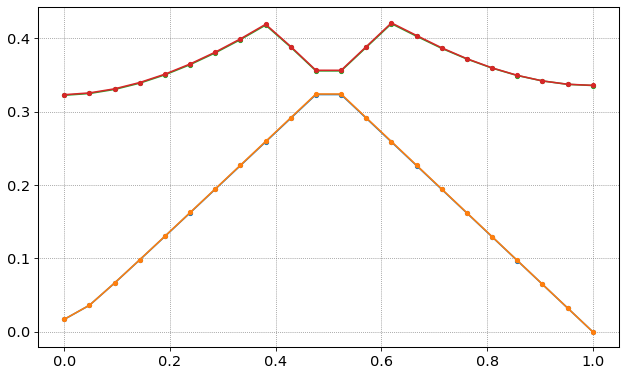

In [6]:
# visualize dispersion

plt.plot(kz,ω,'.-')

epsilon: 2.10987-2.61735, mean 2.16695, harm. mean 2.15741, 100% > 1, 11.2472% "fill"


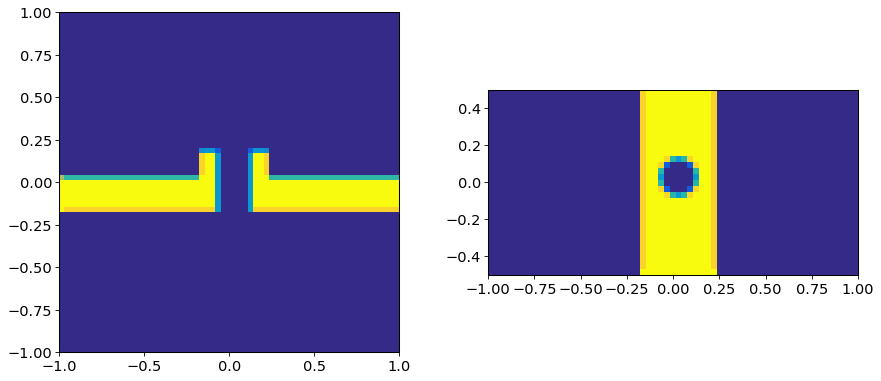

In [27]:
# visualize ε(x,y,z) and mode fields
ε = ms.get_epsilon()
figsize= 14, 6
xlim = -2,2
ylim = -2,2
zlim = -1,1

fig, ax = plt.subplots(1,2,figsize=(figsize))

yind = int(ny/2) + 1
zind = int(nz/2) 

ax[0].pcolormesh(x,y,ε[:,:,zind].T)
ax[1].pcolormesh(x,z,ε[:,yind,:].T)

for aa in ax.flatten():
    aa.set_aspect('equal')

In [4]:
ω

1.1764705882352942

In [12]:
neff

NameError: name 'neff' is not defined

# create structure as MEEP sim to visualize

In [63]:
sim = mp.Simulation(resolution=50,
                    cell_size=mp.Vector3(Xgrid,Ygrid,Zgrid),
                    geometry=geom)

sim.init_sim()

eps_data = sim.get_epsilon()

-----------
Initializing structure...
time for choose_chunkdivision = 6.91414e-06 s
Working in 3D dimensions.
Computational cell is 2 x 2 x 1 with resolution 50
     prism, center = (0,0,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-0.4,0.15,0)
          (0.4,0.15,0)
          (0.4,-0.15,0)
          (-0.4,-0.15,0)
          dielectric constant epsilon diagonal = (2.61735,2.61735,2.61735)
     block, center = (0,-0.1,0)
          size (1e+20,0.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.61735,2.61735,2.61735)
     cylinder, center = (0,0,0)
          radius 0.1, height 1e+20, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (2.10987,2.10987,2.10987)
time for set_epsilon = 2.07627 s
-----------


In [ ]:
sim.plot3D()